## Data Read-In helper functions

In [9]:
from pathlib import Path
from rosbags.typesys import get_typestore, Stores, get_types_from_msg
from rosbags.rosbag2 import Reader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

typestore = get_typestore(Stores.ROS2_HUMBLE)


def register_msg_file(typestore, msg_path: str, full_type_name: str):
    msg_text = Path(msg_path).read_text()
    add_types = get_types_from_msg(msg_text, full_type_name)
    typestore.register(add_types)

def bag_to_df_gps(bag_path: str, typestore, topic: str = "/gps") -> pd.DataFrame:
    rows = []

    with Reader(bag_path) as reader:
        for connection, timestamp, rawdata in reader.messages():
            if connection.topic != topic:
                continue

            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)

            rows.append({
                "bag_time_ns": int(timestamp),

                "stamp_sec": int(msg.header.stamp.sec),
                "stamp_nanosec": int(msg.header.stamp.nanosec),
                "frame_id": str(msg.header.frame_id),

                "latitude": float(msg.latitude),
                "longitude": float(msg.longitude),
                "altitude": float(msg.altitude),
                "hdop": float(msg.hdop),

                "utm_easting": float(msg.utm_easting),
                "utm_northing": float(msg.utm_northing),

                "utc": str(msg.utc),
                "zone": str(msg.zone),
                "letter": str(msg.letter),
            })

    return pd.DataFrame(rows)


def bag_to_df_rtk(bag_path: str, typestore, topic: str = "/rtk") -> pd.DataFrame:
    rows = []

    with Reader(bag_path) as reader:
        for connection, timestamp, rawdata in reader.messages():
            if connection.topic != topic:
                continue

            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)

            rows.append({
                "bag_time_ns": int(timestamp),

                "stamp_sec": int(msg.header.stamp.sec),
                "stamp_nanosec": int(msg.header.stamp.nanosec),
                "frame_id": str(msg.header.frame_id),

                "latitude": float(msg.latitude),
                "longitude": float(msg.longitude),
                "altitude": float(msg.altitude),

                "utm_easting": float(msg.utm_easting),
                "utm_northing": float(msg.utm_northing),
                "zone": str(msg.zone),
                "letter": str(msg.letter),

                "utc": str(msg.utc),

                # RTK-specific fields you said are guaranteed:
                "gngga": str(msg.gngga),
                "fix_quality": int(msg.fix_quality),
                "hdop": float(msg.hdop),
            })

    return pd.DataFrame(rows)

# trim dataframes to the same length (for easier plotting)
def trim_to_duration(df, T):
    t = (df["bag_time_ns"] - df["bag_time_ns"].iloc[0]) * 1e-9
    return df.loc[t <= T].copy()

## Register Messages

In [10]:
# --- Register RTK msg ---
register_msg_file(
    typestore,
    "src/rtk_driver_msgs/msg/CustomRTK.msg",
    "rtk_driver_msgs/msg/CustomRTK"
)
# --- Register GPS msg (from the other package) ---
register_msg_file(
    typestore,
    "../LAB1/src/gps_driver_msgs/msg/GpsMsg.msg",
    "gps_driver_msgs/msg/GpsMsg"
)

## Data Processing

In [41]:
rtk_open_df = bag_to_df_rtk("data/openRTK", typestore, topic="/rtk")
rtk_occluded_df = bag_to_df_rtk("data/occludedRTK", typestore, topic="/rtk")
rtk_walking_df = bag_to_df_rtk("data/walkingRTK", typestore, topic="/rtk")

gps_open_df = bag_to_df_gps("data/humble_open_run", typestore, topic="/gps")
gps_occluded_df = bag_to_df_gps("data/humble_occluded_run", typestore, topic="/gps")
gps_walking_df = bag_to_df_gps("data/humble_straight_line_run", typestore, topic="/gps")

# from lab 1 we know that we have to clip some values in the walking dataset 
gps_walking_df = gps_walking_df.iloc[290:430].copy()

# T = min(
#     (rtk_open_df["bag_time_ns"].iloc[-1] - rtk_open_df["bag_time_ns"].iloc[0]) * 1e-9,
#     (rtk_occluded_df["bag_time_ns"].iloc[-1] - rtk_occluded_df["bag_time_ns"].iloc[0]) * 1e-9
# )

# rtk_open_df = trim_to_duration(rtk_open_df, T)
# rtk_occluded_df = trim_to_duration(rtk_occluded_df, T)
# gps_open_df = trim_to_duration(gps_open_df, T)
# gps_occluded_df = trim_to_duration(gps_occluded_df, T)

# Print Columns for Refrence

In [42]:
# print columns in gps and rtk dataframes 
print("RTK columns:", rtk_open_df.columns)
print()
print("GPS columns:", gps_open_df.columns)

RTK columns: Index(['bag_time_ns', 'stamp_sec', 'stamp_nanosec', 'frame_id', 'latitude',
       'longitude', 'altitude', 'utm_easting', 'utm_northing', 'zone',
       'letter', 'utc', 'gngga', 'fix_quality', 'hdop'],
      dtype='object')

GPS columns: Index(['bag_time_ns', 'stamp_sec', 'stamp_nanosec', 'frame_id', 'latitude',
       'longitude', 'altitude', 'hdop', 'utm_easting', 'utm_northing', 'utc',
       'zone', 'letter'],
      dtype='object')


In [43]:
print("\nRTK Open DataFrame Shape:", rtk_open_df.shape)
print("RTK Occluded DataFrame Shape:", rtk_occluded_df.shape)

rtk_open_df.tail()


RTK Open DataFrame Shape: (318, 15)
RTK Occluded DataFrame Shape: (305, 15)


,bag_time_ns,stamp_sec,stamp_nanosec,frame_id,latitude,longitude,altitude,utm_easting,utm_northing,zone,letter,utc,gngga,fix_quality,hdop
313,1770835157996412539,60933,0,GPS1_Frame,42.338239,-71.086508,23.222,328114.896648,4.689440e+06,19,T,165533.00,"$GNGGA,165533.00,4220.2943334,N,07105.1904799,...",4,0.9
314,1770835159272346125,60934,0,GPS1_Frame,42.338239,-71.086508,23.221,328114.896648,4.689440e+06,19,T,165534.00,"$GNGGA,165534.00,4220.2943334,N,07105.1904799,...",4,0.9
315,1770835160551956313,60935,0,GPS1_Frame,42.338239,-71.086508,23.221,328114.896648,4.689440e+06,19,T,165535.00,"$GNGGA,165535.00,4220.2943334,N,07105.1904799,...",4,0.9
316,1770835161823254507,60936,0,GPS1_Frame,42.338239,-71.086508,23.221,328114.896644,4.689440e+06,19,T,165536.00,"$GNGGA,165536.00,4220.2943333,N,07105.1904799,...",4,0.9
317,1770835163106257495,60937,0,GPS1_Frame,42.338239,-71.086508,23.221,328114.896644,4.689440e+06,19,T,165537.00,"$GNGGA,165537.00,4220.2943333,N,07105.1904799,...",4,0.9


## Plotting Functions

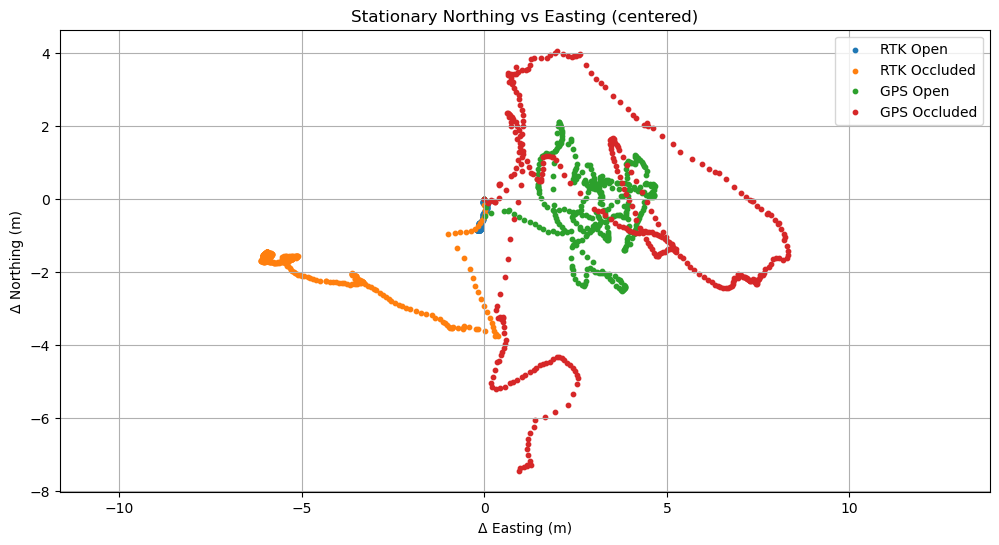

In [44]:
def plot_all_stationary_scatter(title="Stationary Northing vs Easting (centered)"):
    plt.figure(figsize=(12, 6))

    for i, (df, label) in enumerate([(rtk_open_df, "RTK Open"), (rtk_occluded_df, "RTK Occluded"), (gps_open_df, "GPS Open"), (gps_occluded_df, "GPS Occluded")]):
        d = df.copy()
        d["de"] = d["utm_easting"]  - d["utm_easting"].iloc[0]
        d["dn"] = d["utm_northing"] - d["utm_northing"].iloc[0]

        plt.scatter(d["de"], d["dn"], s=10, marker="o", label=label)

    plt.xlabel("Δ Easting (m)")
    plt.ylabel("Δ Northing (m)")
    plt.title(title)
    plt.axis("equal")      # important so x/y are same scale
    plt.grid(True)
    plt.legend()
    plt.show()

plot_all_stationary_scatter()

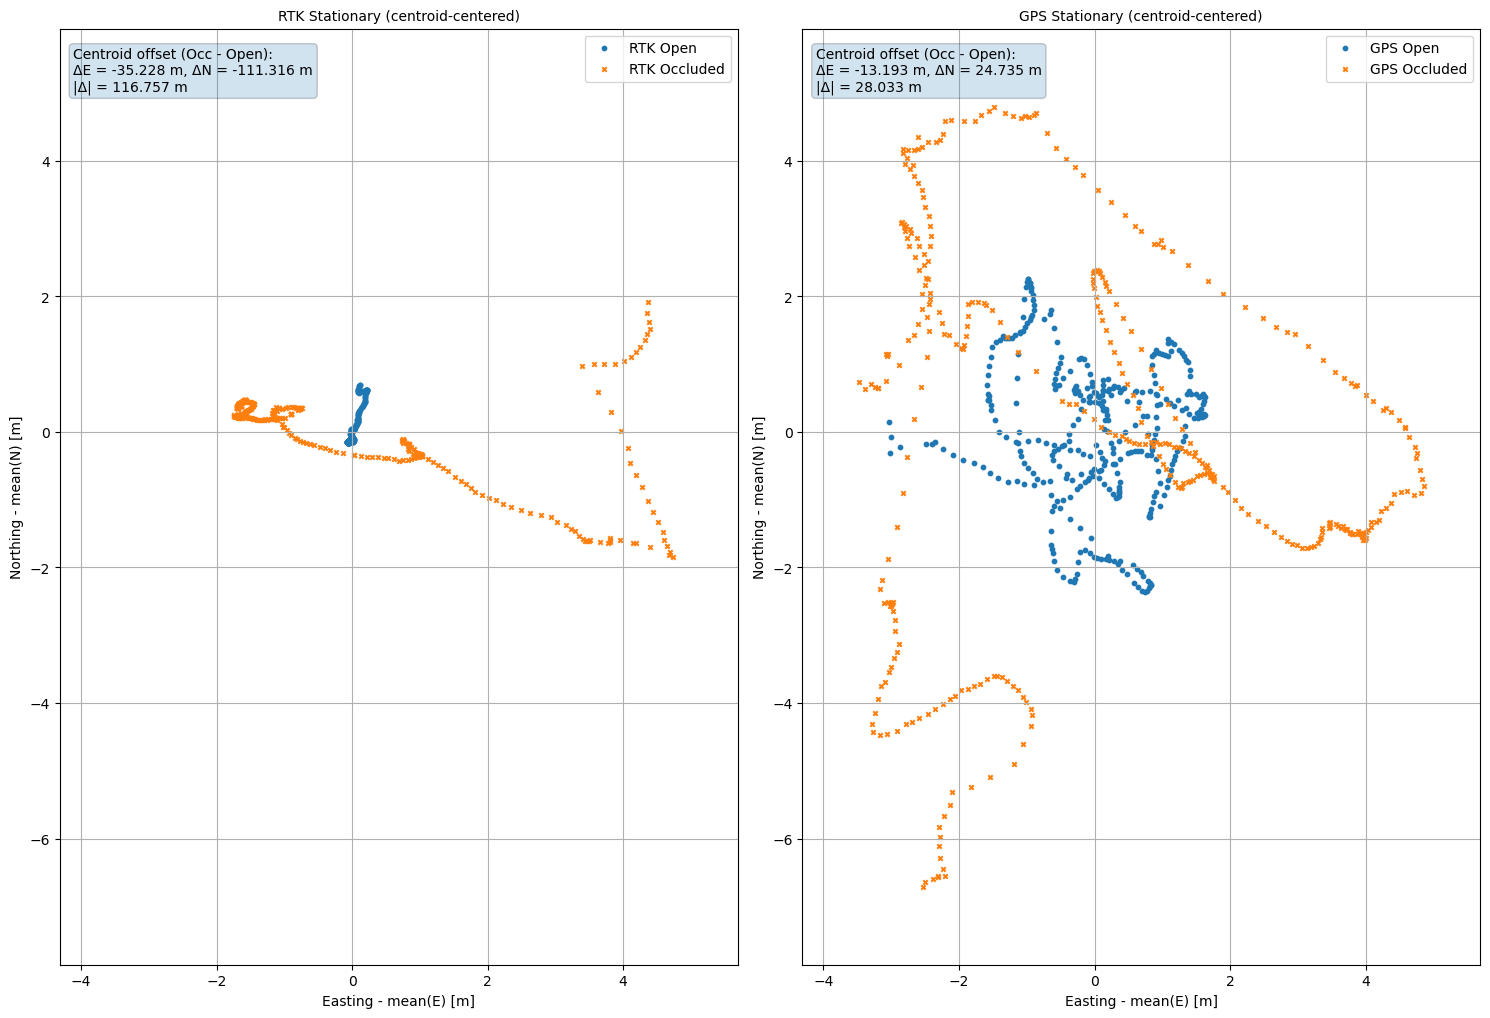

In [70]:
from matplotlib.patches import Circle

def plot_stationary_scatter(title="Stationary Northing vs Easting (centroid-centered)"):

    # Copy so originals untouched
    d1 = rtk_open_df.copy()
    d2 = rtk_occluded_df.copy()
    d3 = gps_open_df.copy()
    d4 = gps_occluded_df.copy()

    def center_by_centroid(d):
        e0 = d["utm_easting"].mean()
        n0 = d["utm_northing"].mean()
        d["de"] = d["utm_easting"] - e0
        d["dn"] = d["utm_northing"] - n0
        return d, e0, n0

    # Center each dataset by its own centroid
    d1, e1, n1 = center_by_centroid(d1)  # RTK open
    d2, e2, n2 = center_by_centroid(d2)  # RTK occluded
    d3, e3, n3 = center_by_centroid(d3)  # GPS open
    d4, e4, n4 = center_by_centroid(d4)  # GPS occluded

    # "Total offset" = centroid bias (occluded - open)
    rtk_off_e, rtk_off_n = (e2 - e1), (n2 - n1)
    gps_off_e, gps_off_n = (e4 - e3), (n4 - n3)
    rtk_off_mag = np.hypot(rtk_off_e, rtk_off_n)
    gps_off_mag = np.hypot(gps_off_e, gps_off_n)

    # Shared axis limits across ALL 4 (so you can visually compare spreads)
    all_de = pd.concat([d1["de"], d2["de"], d3["de"], d4["de"]], ignore_index=True)
    all_dn = pd.concat([d1["dn"], d2["dn"], d3["dn"], d4["dn"]], ignore_index=True)
    x_min, x_max = all_de.min(), all_de.max()
    y_min, y_max = all_dn.min(), all_dn.max()

    pad = 0.1
    xr = x_max - x_min
    yr = y_max - y_min
    x_min, x_max = x_min - pad * xr, x_max + pad * xr
    y_min, y_max = y_min - pad * yr, y_max + pad * yr

    fig, ax = plt.subplots(1, 2, figsize=(15, 11))

    # ---- RTK subplot ----
    ax[0].scatter(d1["de"], d1["dn"], s=10, marker="o", label="RTK Open")
    ax[0].scatter(d2["de"], d2["dn"], s=10, marker="x", label="RTK Occluded")

    
    ax[0].set_xlabel("Easting - mean(E) [m]")
    ax[0].set_ylabel("Northing - mean(N) [m]")
    ax[0].set_title("RTK Stationary (centroid-centered)", size=10)
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)
    ax[0].set_aspect("equal", adjustable="box")
    ax[0].grid(True)
    ax[0].legend()

    ax[0].text(
        0.02, 0.98,
        f"Centroid offset (Occ - Open):\n"
        f"ΔE = {rtk_off_e:.3f} m, ΔN = {rtk_off_n:.3f} m\n"
        f"|Δ| = {rtk_off_mag:.3f} m",
        transform=ax[0].transAxes,
        va="top",
        bbox=dict(boxstyle="round", alpha=0.2)
    )

    # ---- GPS subplot ----
    ax[1].scatter(d3["de"], d3["dn"], s=10, marker="o", label="GPS Open")
    ax[1].scatter(d4["de"], d4["dn"], s=10, marker="x", label="GPS Occluded")
    ax[1].set_xlabel("Easting - mean(E) [m]")
    ax[1].set_ylabel("Northing - mean(N) [m]")
    ax[1].set_title("GPS Stationary (centroid-centered)" , size=10)
    ax[1].set_xlim(x_min, x_max)
    ax[1].set_ylim(y_min, y_max)
    ax[1].set_aspect("equal", adjustable="box")
    ax[1].grid(True)
    ax[1].legend()

    ax[1].text(
        0.02, 0.98,
        f"Centroid offset (Occ - Open):\n"
        f"ΔE = {gps_off_e:.3f} m, ΔN = {gps_off_n:.3f} m\n"
        f"|Δ| = {gps_off_mag:.3f} m",
        transform=ax[1].transAxes,
        va="top",
        bbox=dict(boxstyle="round", alpha=0.2)
    )

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


plot_stationary_scatter()

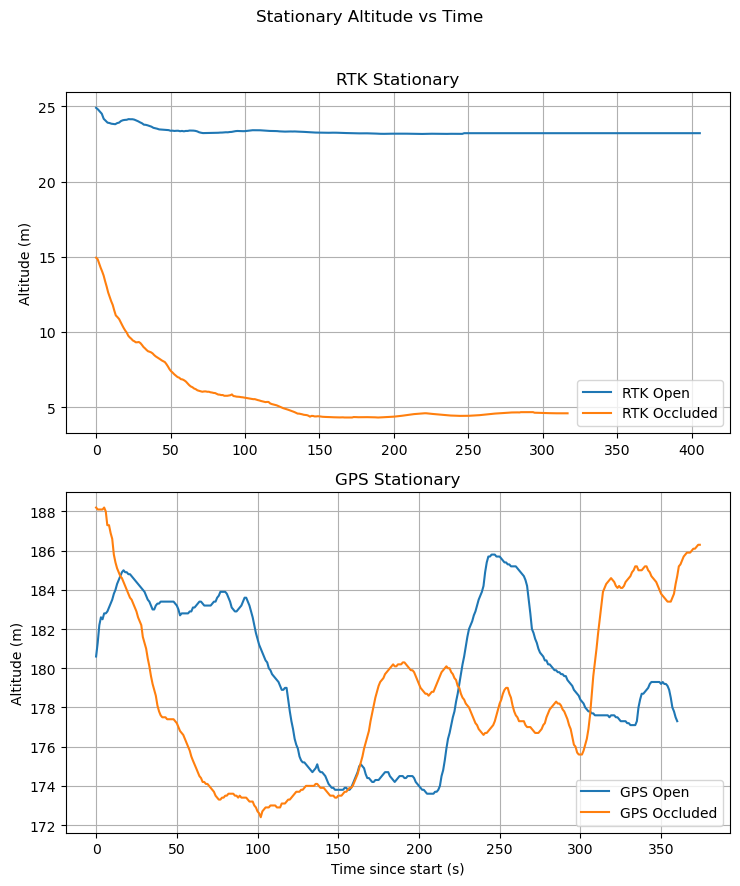

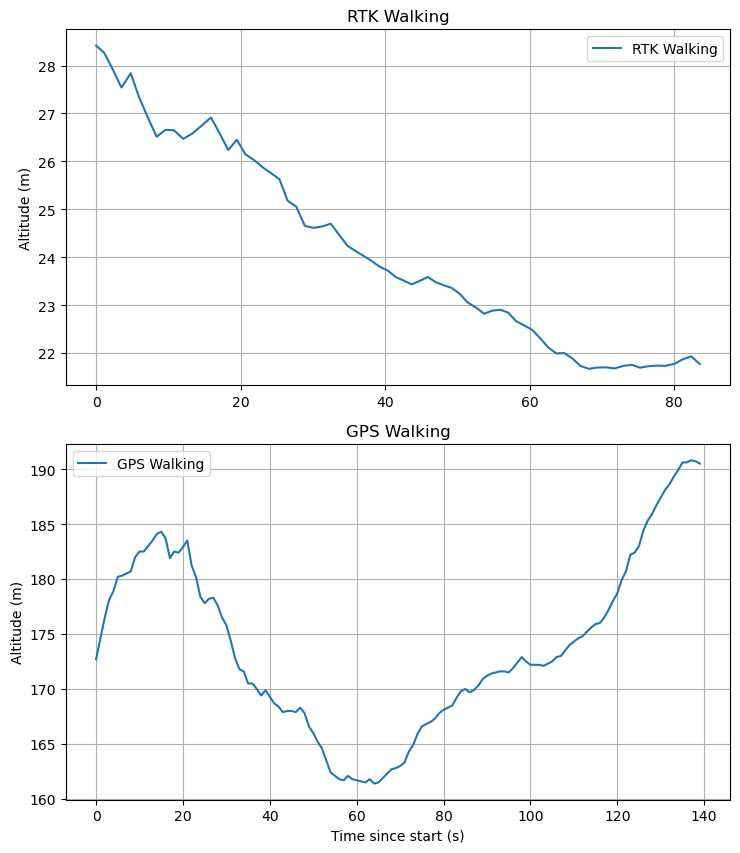

In [68]:
import matplotlib.pyplot as plt

def plot_all_stationary_altitude(title="Stationary Altitude vs Time"):

    fig, ax = plt.subplots(2, 1, figsize=(7.5, 9), sharex=False)
    fig.suptitle(title)

    # ---------- RTK ----------
    t_rtk_open = (rtk_open_df["bag_time_ns"] - rtk_open_df["bag_time_ns"].iloc[0]) * 1e-9
    t_rtk_occ  = (rtk_occluded_df["bag_time_ns"] - rtk_occluded_df["bag_time_ns"].iloc[0]) * 1e-9

    ax[0].plot(t_rtk_open, rtk_open_df["altitude"], label="RTK Open")
    ax[0].plot(t_rtk_occ,  rtk_occluded_df["altitude"], label="RTK Occluded")

    ax[0].set_title("RTK Stationary")
    ax[0].set_ylabel("Altitude (m)")
    ax[0].grid(True)
    ax[0].legend()

    # ---------- GPS ----------
    t_gps_open = (gps_open_df["bag_time_ns"] - gps_open_df["bag_time_ns"].iloc[0]) * 1e-9
    t_gps_occ  = (gps_occluded_df["bag_time_ns"] - gps_occluded_df["bag_time_ns"].iloc[0]) * 1e-9

    ax[1].plot(t_gps_open, gps_open_df["altitude"], label="GPS Open")
    ax[1].plot(t_gps_occ,  gps_occluded_df["altitude"], label="GPS Occluded")

    ax[1].set_title("GPS Stationary")
    ax[1].set_xlabel("Time since start (s)")
    ax[1].set_ylabel("Altitude (m)")
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_all_stationary_altitude()

import matplotlib.pyplot as plt

def plot_all_walking_altitude(title="Walking Altitude vs Time"):

    fig, ax = plt.subplots(2, 1, figsize=(7.5, 9), sharex=False)

    # ---------- RTK Walking ----------
    t_rtk = (rtk_walking_df["bag_time_ns"] - rtk_walking_df["bag_time_ns"].iloc[0]) * 1e-9

    ax[0].plot(t_rtk, rtk_walking_df["altitude"], label="RTK Walking")
    ax[0].set_title("RTK Walking")
    ax[0].set_ylabel("Altitude (m)")
    ax[0].grid(True)
    ax[0].legend()

    # ---------- GPS Walking ----------
    t_gps = (gps_walking_df["bag_time_ns"] - gps_walking_df["bag_time_ns"].iloc[0]) * 1e-9

    ax[1].plot(t_gps, gps_walking_df["altitude"], label="GPS Walking")
    ax[1].set_title("GPS Walking")
    ax[1].set_xlabel("Time since start (s)")
    ax[1].set_ylabel("Altitude (m)")
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_all_walking_altitude()

bin size RTK: 0.175 m, GPS: 0.247 m


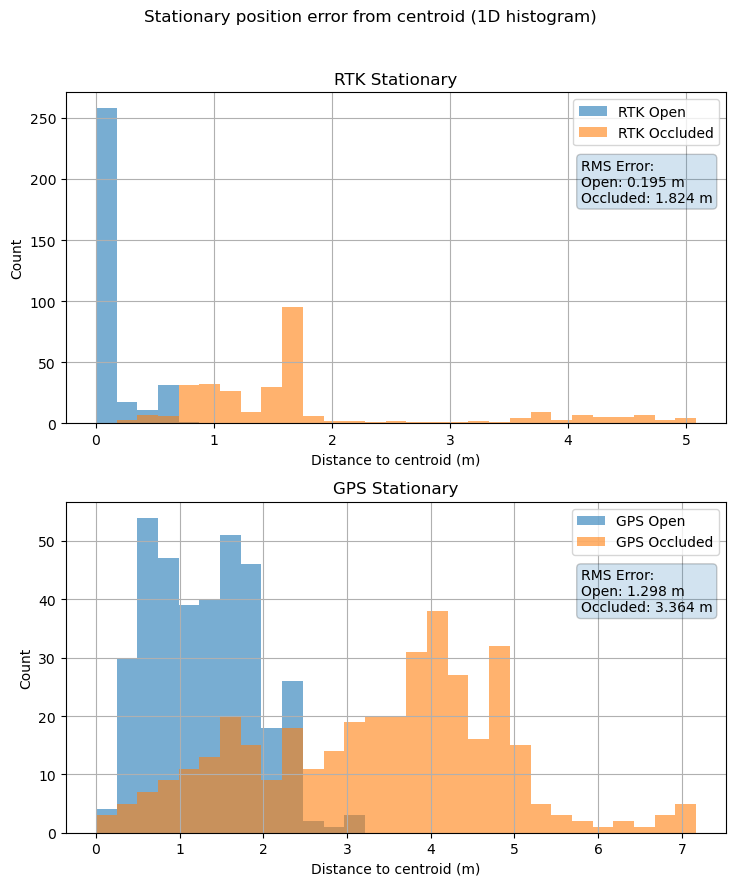

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def radial_distance_from_centroid(df):
    e0 = df["utm_easting"].mean()
    n0 = df["utm_northing"].mean()
    de = df["utm_easting"] - e0
    dn = df["utm_northing"] - n0
    r = np.sqrt(de**2 + dn**2)
    return r

def plot_stationary_position_histograms(title="Stationary position error from centroid (1D histogram)"):
    # Compute radial distances
    r_rtk_open = radial_distance_from_centroid(rtk_open_df)
    r_rtk_occ  = radial_distance_from_centroid(rtk_occluded_df)
    r_gps_open = radial_distance_from_centroid(gps_open_df)
    r_gps_occ  = radial_distance_from_centroid(gps_occluded_df)

    # Shared binning so open vs occluded comparisons are fair per sensor type
    # (RTK and GPS can have different scales, so bins are computed per subplot)
    rtk_max = max(r_rtk_open.max(), r_rtk_occ.max())
    gps_max = max(r_gps_open.max(), r_gps_occ.max())

    rtk_bins = np.linspace(0, rtk_max, 30)
    gps_bins = np.linspace(0, gps_max, 30)

    print(f"bin size RTK: {(rtk_bins[1] - rtk_bins[0]):.3f} m, GPS: {(gps_bins[1] - gps_bins[0]):.3f} m")

    fig, ax = plt.subplots(2, 1, figsize=(7.5, 9))
    fig.suptitle(title)

    # ----- RTK -----
    ax[0].hist(r_rtk_open, bins=rtk_bins, alpha=0.6, label="RTK Open")
    ax[0].hist(r_rtk_occ,  bins=rtk_bins, alpha=0.6, label="RTK Occluded")
    ax[0].set_title("RTK Stationary")
    ax[0].set_xlabel("Distance to centroid (m)")
    ax[0].set_ylabel("Count")
    ax[0].grid(True)
    ax[0].legend()

    ax[0].text(
        0.78, 0.8,
        f"RMS Error:\n"
        f"Open: {r_rtk_open.mean():.3f} m\n"
        f"Occluded: {r_rtk_occ.mean():.3f} m",
        transform=ax[0].transAxes,
        va="top",
        bbox=dict(boxstyle="round", alpha=0.2)
    )

    # ----- GPS -----
    ax[1].hist(r_gps_open, bins=gps_bins, alpha=0.6, label="GPS Open")
    ax[1].hist(r_gps_occ,  bins=gps_bins, alpha=0.6, label="GPS Occluded")
    ax[1].set_title("GPS Stationary")
    ax[1].set_xlabel("Distance to centroid (m)")
    ax[1].set_ylabel("Count")
    ax[1].grid(True)
    ax[1].legend()

    ax[1].text(
        0.78, 0.8,
        f"RMS Error:\n"
        f"Open: {r_gps_open.mean():.3f} m\n"
        f"Occluded: {r_gps_occ.mean():.3f} m",
        transform=ax[1].transAxes,
        va="top",
        bbox=dict(boxstyle="round", alpha=0.2,)
    )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_stationary_position_histograms()

In [54]:
def rms_position_error_from_centroid(df):
    r = radial_distance_from_centroid(df)   # r_i = sqrt(de^2 + dn^2)
    return float(np.sqrt(np.mean(r**2)).round(4))

gps_rms_open    = rms_position_error_from_centroid(gps_open_df)
gps_rms_occluded = rms_position_error_from_centroid(gps_occluded_df)
rtk_rms_open    = rms_position_error_from_centroid(rtk_open_df)
rtk_rms_occluded = rms_position_error_from_centroid(rtk_occluded_df)

print("RMS Open (m):", gps_rms_open, "(GPS),", rtk_rms_open, "(RTK)")
print("RMS Occluded (m):", gps_rms_occluded, "(GPS),", rtk_rms_occluded, "(RTK)")





RMS Open (m): 1.4398 (GPS), 0.2536 (RTK)
RMS Occluded (m): 3.6676 (GPS), 2.1554 (RTK)


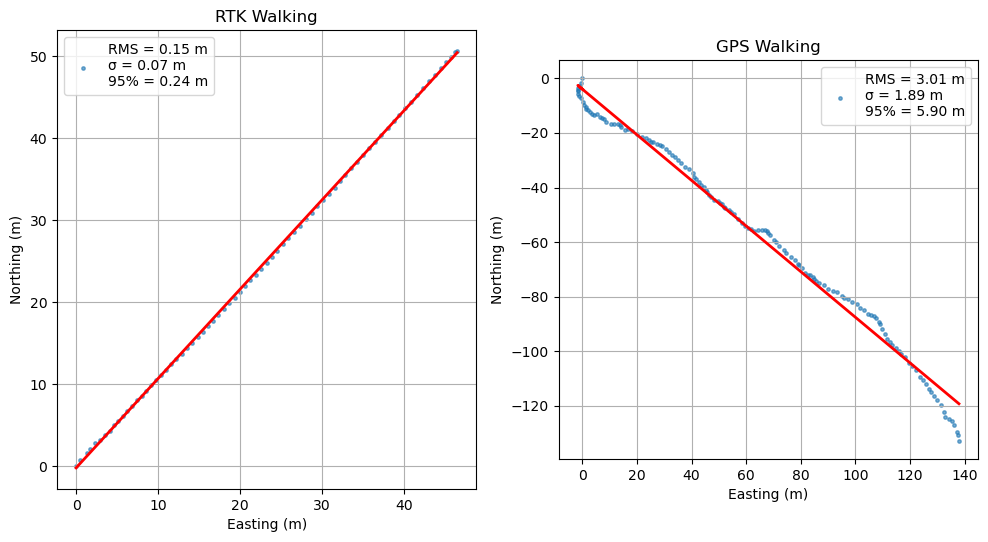

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def plot_line_fit_error_2x1(df1, df2, title1="Dataset 1", title2="Dataset 2"):

    fig, ax = plt.subplots(1, 2, figsize=(10, 14))

    for axis, df, title in zip(ax, [df1, df2], [title1, title2]):

        E = df["utm_easting"].to_numpy()
        N = df["utm_northing"].to_numpy()
        E = E - E[0]
        N = N - N[0]

        # ---- fit line ----
        m, b = np.polyfit(E, N, 1)
        N_fit = m * E + b

        # ---- perpendicular distance ----
        error = np.abs(m*E - N + b) / np.sqrt(m**2 + 1)

        rms_val = np.sqrt((error**2).mean())
        std_val = error.std()
        p95_val = np.percentile(error, 95)

        legend_label = (
            f"RMS = {rms_val:.2f} m\n"
            f"σ = {std_val:.2f} m\n"
            f"95% = {p95_val:.2f} m"
        )

        axis.scatter(E, N, s=6, alpha=0.6)
        axis.plot(E, N_fit, 'r', linewidth=2)
        axis.set_xlabel("Easting (m)")
        axis.set_ylabel("Northing (m)")
        axis.set_title(title)
        axis.legend([legend_label])
        axis.set_aspect("equal", adjustable="box")
        axis.grid(True)

    plt.tight_layout()
    plt.show()

plot_line_fit_error_2x1(rtk_walking_df, gps_walking_df, title1="RTK Walking", title2="GPS Walking")